In [6]:
#Sentiment Analysis on Elon Musk's tweets and look for relationships between his tweets and TESLA stock prices.
import pandas as pd
import os

# Load the dataset
here = os.getcwd()
input_dir = os.path.abspath(os.path.join(here, os.pardir))
file_path = os.path.join(input_dir, 'elon_musk_tweets.csv')
tesla_stock_data_path = os.path.join(input_dir, 'TSLA.csv')
elon_tweets = pd.read_csv(file_path)
tesla_stock_prices = pd.read_csv(tesla_stock_data_path)

# Display the first few rows of each dataframe
(elon_tweets.head(), tesla_stock_prices.head())

(                    id  user_name user_location           user_description  \
 0  1544379368478212100  Elon Musk           NaN  Mars & Cars, Chips & Dips   
 1  1544377493263720450  Elon Musk           NaN  Mars & Cars, Chips & Dips   
 2  1544377130590552064  Elon Musk           NaN  Mars & Cars, Chips & Dips   
 3  1544375575724400645  Elon Musk           NaN  Mars & Cars, Chips & Dips   
 4  1544375148605853699  Elon Musk           NaN  Mars & Cars, Chips & Dips   
 
                 user_created  user_followers  user_friends  user_favourites  \
 0  2009-06-02 20:12:29+00:00       101240855           115            13503   
 1  2009-06-02 20:12:29+00:00       101240806           115            13503   
 2  2009-06-02 20:12:29+00:00       101240806           115            13503   
 3  2009-06-02 20:12:29+00:00       101240806           115            13503   
 4  2009-06-02 20:12:29+00:00       101240806           115            13503   
 
    user_verified                       da

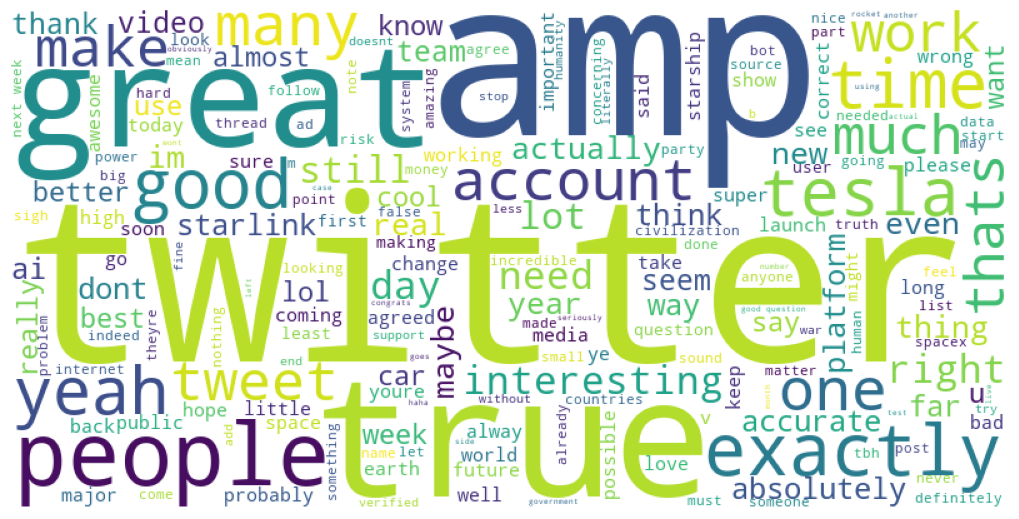

In [7]:
#lets try to creat a word cloud to see Elon's most frequent words used for last year
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
# define a basic list of English stopwords 
basic_stopwords = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
    "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers",
    "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
    "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are",
    "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does",
    "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until",
    "while", "of", "at", "by", "for", "with", "about", "against", "between", "into",
    "through", "during", "before", "after", "above", "below", "to", "from", "up", "down",
    "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
    "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more",
    "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",
    "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"
])

# Function to clean tweet text using basic tokenization (splitting by spaces) and manual stopwords
def clean_text_basic_manual(text):
    # Convert to lower case
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove usernames
    text = re.sub(r'@\S+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize by splitting by spaces and remove stopwords
    tokens = text.split()
    filtered_words = [word for word in tokens if word not in basic_stopwords]
    return ' '.join(filtered_words)

# Apply the updated cleaning function to the tweets
elon_tweets['clean_text_manual'] = elon_tweets['text'].apply(clean_text_basic_manual)

# Generate word cloud using manually cleaned text
wordcloud_manual = WordCloud(width = 800, height = 400, background_color ='white').generate(' '.join(elon_tweets['clean_text_manual']))

# Display the WordCloud image                      
plt.figure(figsize = (10, 5), facecolor = None) 
plt.imshow(wordcloud_manual) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

In [8]:
#now let's conduct the sentiment analysis using SVM, KNN, Naive Bayes and see which model perform the best
from textblob import TextBlob

# Function to assign sentiments using TextBlob，TextBlob is a library that can generate sentiment labels (positive, negative, neutral) based on the text, we will use the labels generated for our training
def assign_sentiment(text):
    analysis = TextBlob(text)
    # TextBlob returns polarity in the range of -1 to 1
    # where -1 is negative, 1 is positive, and 0 is neutral
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

# Apply sentiment assignment function to the cleaned texts
elon_tweets['sentiment'] = elon_tweets['clean_text_manual'].apply(assign_sentiment)

# Display the distribution of sentiments
elon_tweets['sentiment'].value_counts()


sentiment
positive    2619
neutral     2498
negative     787
Name: count, dtype: int64

In [9]:
#let's process our tweets data by vectorize them using Term Frequency - Inverse Document Frequency (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Filter out neutral sentiments for binary classification
binary_tweets = elon_tweets[elon_tweets['sentiment'] != 'neutral']

# Vectorize the tweets text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(binary_tweets['clean_text_manual'])

# Encode labels: positive as 1 and negative as 0
y = binary_tweets['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Check the dimentions of the training and testing sets
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((2724, 1000), (682, 1000), (2724,), (682,))

In [10]:
#now for the sake of robustness, I want to ultilize grid search with 5 fold cross validation to find the optimal number of neighbors for Knn and kernel types for SVM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Setting up the parameter grid for KNN
knn_params = {'n_neighbors': range(1, 31, 2)}  # Testing odd numbers from 1 to 30
knn = KNeighborsClassifier()

# Setup GridSearchCV
knn_grid_search = GridSearchCV(knn, knn_params, cv=5, scoring='accuracy', verbose=1)
knn_grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for KNN:", knn_grid_search.best_params_)
print("Best cross-validation score for KNN:", knn_grid_search.best_score_)

from sklearn.svm import SVC

# Setting up the parameter grid for SVM
svm_params = {'kernel': ['linear', 'rbf', 'poly']}
svm = SVC()

# Setup GridSearchCV
svm_grid_search = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy', verbose=1)
svm_grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for SVM:", svm_grid_search.best_params_)
print("Best cross-validation score for SVM:", svm_grid_search.best_score_)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters for KNN: {'n_neighbors': 3}
Best cross-validation score for KNN: 0.8142431192660551
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for SVM: {'kernel': 'linear'}
Best cross-validation score for SVM: 0.8869320021586617


In [11]:
#now we can go ahead and train our models with the optimal parameters 
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize the models with the best parameters found
knn_model = KNeighborsClassifier(n_neighbors=3)
svm_model = SVC(kernel='linear')
nb_model = MultinomialNB()  #default paramenters will be used for Naive Bayes

# Train Naive Bayes
nb_model.fit(X_train, y_train)
# Train KNN
knn_model.fit(X_train, y_train)
# Train SVM
svm_model.fit(X_train, y_train)

# Predictions
nb_predictions = nb_model.predict(X_test)
knn_predictions = knn_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)

# Evaluate models
models = ['Naive Bayes', 'KNN', 'SVM']
predictions = [nb_predictions, knn_predictions, svm_predictions]

# Dictionary to hold evaluation metrics
evaluation_metrics = {}

for model, prediction in zip(models, predictions):
    evaluation_metrics[model] = {
        'Accuracy': accuracy_score(y_test, prediction),
        'Precision': precision_score(y_test, prediction),
        'Recall': recall_score(y_test, prediction),
        'F1 Score': f1_score(y_test, prediction) #F1 score for checking the reliability of our models
    }

# Print the evaluation metrics for each model
for model, metrics in evaluation_metrics.items():
    print(f"Metrics for {model}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print()  # Print another line for seperation purpose

Metrics for Naive Bayes:
Accuracy: 0.8666
Precision: 0.8576
Recall: 0.9944
F1 Score: 0.9209

Metrics for KNN:
Accuracy: 0.8372
Precision: 0.8414
Recall: 0.9756
F1 Score: 0.9036

Metrics for SVM:
Accuracy: 0.9032
Precision: 0.9104
Recall: 0.9719
F1 Score: 0.9401



Upon checking the results above, the SVM model performed the best in terms of accuracy and F1 score, closely followed by the Naive Bayes model. KNN lagged behind the other two, which might be due to its sensitivity to the high-dimensional space created by TF-IDF.
Now we can finally look at some interesting stuff: find out whether Elon's tweets affect Tesla's stock prices!

In [12]:
#we need to extract the sentiment scores based on the date then we can compare that with Tesla stock price movements
# Convert date to datetime and extract the date part
elon_tweets['date_only'] = pd.to_datetime(elon_tweets['date']).dt.date

# Map sentiments to numeric scores
sentiment_scores = {'positive': 1, 'neutral': 0, 'negative': -1}
elon_tweets['sentiment_score'] = elon_tweets['sentiment'].map(sentiment_scores)

# Group by date and calculate the average sentiment score per day
daily_sentiment_scores = elon_tweets.groupby('date_only')['sentiment_score'].mean().reset_index()

# Show the first few rows of the daily sentiment scores
daily_sentiment_scores.head()

,date_only,sentiment_score
0,2022-07-05,0.222222
1,2022-07-06,0.384615
2,2022-07-07,0.578947
3,2022-07-08,0.363636
4,2022-07-11,0.300000


In [13]:
import pandas as pd
# Load Tesla stock data
tesla_stock_prices['Date'] = pd.to_datetime(tesla_stock_prices['Date']).dt.date  # Ensure the date format matches

# Merge the sentiment data with Tesla stock price data
combined_data = pd.merge(daily_sentiment_scores, tesla_stock_prices, left_on='date_only', right_on='Date', how='inner')

# Analyze the correlation between sentiment scores and closing stock prices
correlation = combined_data[['sentiment_score', 'Close']].corr()

# Display the correlation
print(correlation)
#−0.015465 is very close to zero, which suggests a very weak linear relationship between the variables. However, the negative sign indicates a negative correlation, which means that as sentiment scores increase (Elon's tweet sentiment become more positive), Tesla's stock prices tend to decrease slightly, and vice versa.

                 sentiment_score     Close
sentiment_score         1.000000 -0.015465
Close                  -0.015465  1.000000


In [14]:
#time lag analysis to see if there are any differences
import pandas as pd

# Create shifted versions of the sentiment score for various lag days (1 - 7 days)
lags = [1, 2, 3, 5, 7]  # Days to lag
for lag in lags:
    combined_data[f'sentiment_score_lag{lag}'] = combined_data['sentiment_score'].shift(lag)

# Calculate correlation for each lagged sentiment score with the closing stock prices
correlation_results = {}
for lag in lags:
    correlation = combined_data[['sentiment_score_lag' + str(lag), 'Close']].corr().iloc[0, 1]
    correlation_results[f'Lag {lag} days'] = correlation

# Display the correlation results for each lag
correlation_results
#again, very weak correlations between the variables even with time lags which suggests that either the sentiments of the tweets do not significantly influence Tesla’s stock price movements, or any potential influence is not captured linearly within this timeframe. 
#We can see that for day 7, the correlation is weak yet positive, which indicates that as as sentiment scores increase, Tesla's stock price increases as well (and vice versa).
#Stock prices can be influenced by other factors like market influence, geopolitical influence, investors' sentiment and other external factors. Thus, the impact of tweets from Elon Musk could be diluted or overshadowed by those factors which can not be captured by this model. 

{'Lag 1 days': -0.02309349661534736,
 'Lag 2 days': -0.02414386279415843,
 'Lag 3 days': -0.010929598863101816,
 'Lag 5 days': -0.01975522663574028,
 'Lag 7 days': 0.00326443668721866}